<a href="https://colab.research.google.com/github/jellyXuuuuu/CovidNetDeepLearning/blob/main/5_experiement_whole_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import

In [3]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2 as cv
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

import tensorflow.compat.v1 as tf
import os, argparse
import cv2
import pandas as pd
from tqdm import tqdm
import json

# Load files

In [8]:
!cp -r 'drive/MyDrive/covid/models/' .

In [9]:
!cp -r 'drive/MyDrive/covid/labels/' .

In [10]:
!cp -r 'drive/MyDrive/covid/assets/' .

## Load other dataset

In [11]:
# covid-chestxray-dataset
!wget https://github.com/ieee8023/covid-chestxray-dataset/archive/refs/heads/master.zip

--2023-03-13 18:06:59--  https://github.com/ieee8023/covid-chestxray-dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/ieee8023/covid-chestxray-dataset/zip/refs/heads/master [following]
--2023-03-13 18:06:59--  https://codeload.github.com/ieee8023/covid-chestxray-dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [    <=>             ] 525.03M  21.0MB/s    in 25s     

2023-03-13 18:07:24 (21.0 MB/s) - ‘master.zip’ saved [550535079]



In [12]:
!unzip master.zip

Archive:  master.zip
78543292f8b01d5e0ed1d0e15dce71949f0657bb
   creating: covid-chestxray-dataset-master/
   creating: covid-chestxray-dataset-master/.github/
 extracting: covid-chestxray-dataset-master/.github/FUNDING.yml  
   creating: covid-chestxray-dataset-master/.github/workflows/
  inflating: covid-chestxray-dataset-master/.github/workflows/tests.yml  
  inflating: covid-chestxray-dataset-master/.gitignore  
  inflating: covid-chestxray-dataset-master/README.md  
  inflating: covid-chestxray-dataset-master/SCHEMA.md  
   creating: covid-chestxray-dataset-master/annotations/
  inflating: covid-chestxray-dataset-master/annotations/covid-severity-scores.csv  
  inflating: covid-chestxray-dataset-master/annotations/imageannotation_ai_lung_bounding_boxes.json  
   creating: covid-chestxray-dataset-master/annotations/lungVAE-masks/
  inflating: covid-chestxray-dataset-master/annotations/lungVAE-masks/1-s2.0-S0140673620303706-fx1_lrg_mask.png  
  inflating: covid-chestxray-dataset-mas

# whole method

## prepare the model

In [4]:
def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]


def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]


def process_image_file(filepath, top_percent, size):
    if filepath.split(".")[-1] == "npy":
        x_arr = np.load(filepath)
        x_arr = x_arr * 255.0 / x_arr.max()
        img = np.stack((x_arr, x_arr, x_arr), axis=-1)
    else:
        img = cv2.imread(filepath)

    processed_img = crop_top(img, percent=top_percent)
    processed_img = central_crop(processed_img)
    processed_img = cv2.resize(processed_img, (size, size))
    return processed_img, img


'''/////////////////////////main_grad/////////////////////////////'''

def main_grad(args_impath):
  # # add more photo
  # args_impath = "./covid-chestxray-dataset-master/images/000001-1.jpg"
  image_tensor = graph.get_tensor_by_name(args_in_tensorname)
  gradCam = GradCAM(graph=graph, classes = [0,1,2], outLayer=args_out_tensorname, targetLayer=final_conv_name)

  grads = gradCam.compute_grads()

  x, origin_im = process_image_file(args_impath, args_top_percent, args_input_size)
  img_arr = np.asanyarray(x)
  size_upsample = (origin_im.shape[1],origin_im.shape[0]) # (w, h)

  x = x.astype('float32') / 255.0
  output, grads_val = sess.run([gradCam.target, grads[mapping[args_pred_class]]], feed_dict={image_tensor: np.expand_dims(x, axis=0)})

  cam3 = generate_cam(output[0],grads_val[0],size_upsample)

  # Overlay cam on image
  cam3 = np.uint8(255*cam3)
  cam3 = cv2.applyColorMap(cam3, cv2.COLORMAP_JET)
  
  im_name = args_impath.split("/")[-1]
  ext = im_name.split(".")[-1]


  # show!!!!
  cam3_resize = cv.resize(cam3, (224, 224))
  
  # cv2.imwrite("cam-1.png", cam3_resize)
  

  new_im = cam3*0.3 + origin_im*0.5


  # Save the GradCAM
  cv2.imwrite(os.path.join(args_outdir, "{}_{}png".format(args_pred_class, im_name.rstrip(ext))), new_im)

  # print("GradCAM image is save in ", args_outdir)

  # show images:
  # imagepath = "assets/ex-covid.jpeg"
  img_m = cv.imread(args_impath)
  img_m = cv.resize(img_m, (224, 224))

  # display(Image(imagepath))
  cv2_imshow(img_m)  # oringinal
  new_im_2 = cv.resize(new_im, (224, 224))
  cv2_imshow(new_im_2)  # grad-cam

  cv2_imshow(cam3_resize) # grad-cam-explain

  return img_m, new_im_2, cam3_resize

'''/////////////////////////main_grad/////////////////////////////'''

'''/////////////////////////bb_iou/////////////////////////////'''

def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, (xB - xA + 1)) * max(0, (yB - yA + 1))
	print("interarea:", interArea)
	print("xA, yA, xB, yB:", xA, yA, xB, yB)
  
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = ((boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1))
	boxBArea = ((boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1))
	print("boxAArea:", boxAArea)
	print("boxBArea", boxBArea)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	print("boxAArea + boxBArea - interArea: ", boxAArea + boxBArea - interArea)
	print("iou: ", iou)
	# return the intersection over union value
	return iou

'''/////////////////////////bb_iou/////////////////////////////'''






class GradCAM:
    def __init__(self, graph, classes, outLayer, targetLayer=None):
        self.graph = graph
        self.classes = classes
        self.targetLayer = targetLayer
        self.outLayer = outLayer

        if self.targetLayer is None:
            self.target = self.find_target_tensor()
        else:
            self.target = self.graph.get_tensor_by_name(self.targetLayer)

    def find_target_tensor(self):
        """
        Find the last tensor that have 4D shape if targetLayer is not specified.
        :return:
        """
        tensor_names = [t.name for op in tf.get_default_graph().get_operations() for t in op.values() if
                   "save" not in str(t.name)]
        for tensor_name in reversed(tensor_names):
            tensor = self.graph.get_tensor_by_name(tensor_name)
            if len(tensor.shape) == 4:
                return tensor

        raise ValueError("Could not find 4D layer. Cannot apply GradCAM")

    def compute_grads(self):
        results = {} # grads of classes with keys being classes and values being normalized gradients
        for classIdx in self.classes:
            one_hot = tf.sparse_to_dense(classIdx, [len(self.classes)], 1.0)
            signal = tf.multiply(self.graph.get_tensor_by_name(self.outLayer),one_hot)
            loss = tf.reduce_mean(signal)

            grads = tf.gradients(loss, self.target)[0]

            norm_grads = tf.div(grads, tf.sqrt(tf.reduce_mean(tf.square(grads)))+tf.constant(1e-5))

            results[classIdx] = norm_grads

        return results


def generate_cam(conv_layer_out, grads_val, upsample_size):
    weights = np.mean(grads_val, axis=(0,1))
    cam = np.zeros(conv_layer_out.shape[0:2], dtype=np.float32)

    # Weight averaginng
    for i, w in enumerate(weights):
        cam += w*conv_layer_out[:,:,i]

    # Apply reLU
    cam = np.maximum(cam, 0)
    cam = cam/np.max(cam)
    cam = cv2.resize(cam, upsample_size)

    # Convert to 3D
    cam3 = np.expand_dims(cam, axis=2)
    cam3 = np.tile(cam3,[1,1,3])

    return cam3





## use

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


GradCAM image is save in  ./
Current img: ./assets/ex-covid.jpeg


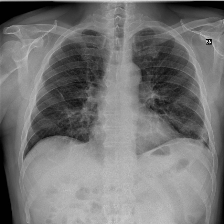

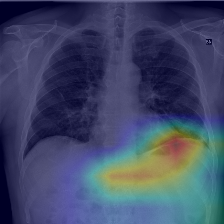

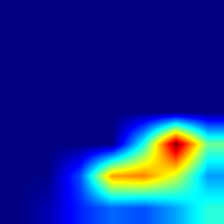

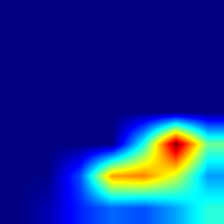

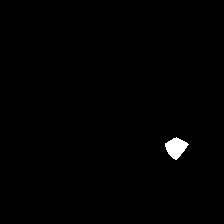

mix is:  137 ; max is:  188
interarea: 2704
xA, yA, xB, yB: 137 137 188 188
boxAArea: 34596
boxBArea 2704
boxAArea + boxBArea - interArea:  34596
iou:  0.07815932477743091


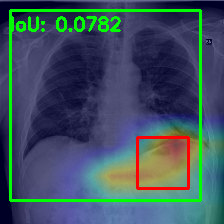

'/////////////////////////main-result/////////////////////////////'

In [13]:
tf.disable_v2_behavior()
weightspath = 'models/COVIDNet-CXR-Large/' 
  
# arguments:
IMAGE_PATH ="assets/ex-covid.jpeg"
output_node_names = "dense_3/Softmax:0" #norm_dense_2/Softmax
final_conv_name="conv5_block3_3_conv/BiasAdd:0"  

model_path = 'models/COVIDNet-CXR-Large/model' #models/COVIDNet-CXR-2/model
model_path2 = 'models/COVIDNet-CXR-Large/model-8485'

metaname = 'model.meta'
ckptname = 'model'
args_n_classes = 2

args_testfolder = 'data/test'
args_trainfile = 'labels/train_COVIDx9B.txt'
args_testfile = 'labels/test_COVIDx9B.txt'

args_out_tensorname = 'dense_3/Softmax:0' #norm_dense_2/Softmax:0
args_logit_tensorname = 'norm_dense_2/MatMul:0'
args_is_severity_model = False
args_is_medusa_backbone = False

args_in_tensorname = 'input_1:0'
args_in_tensorname_medusa = 'input_1:0'
args_input_size = 224 # 480
args_input_size_medusa = 256
args_top_percent = 0.08

# save image
args_impath = "assets/ex-covid.jpeg"
args_pred_class = 'COVID-19'
args_outdir = './'

mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}



# if __name__ == '__main__':
sess = tf.Session()

saver = tf.train.import_meta_graph(model_path + '.meta')

saver.restore(sess, model_path2)

graph = tf.get_default_graph()

image_tensor = graph.get_tensor_by_name(args_in_tensorname)
gradCam = GradCAM(graph=graph, classes = [0,1,2], outLayer=args_out_tensorname, targetLayer=final_conv_name)

grads = gradCam.compute_grads()

x, origin_im = process_image_file(args_impath, args_top_percent, args_input_size)
img_arr = np.asanyarray(x)
size_upsample = (origin_im.shape[1],origin_im.shape[0]) # (w, h)

x = x.astype('float32') / 255.0
output, grads_val = sess.run([gradCam.target, grads[mapping[args_pred_class]]], feed_dict={image_tensor: np.expand_dims(x, axis=0)})

cam3 = generate_cam(output[0],grads_val[0],size_upsample)


# Overlay cam on image
cam3 = np.uint8(255*cam3)
cam3 = cv2.applyColorMap(cam3, cv2.COLORMAP_JET)

new_im = cam3*0.3 + origin_im*0.5

im_name = args_impath.split("/")[-1]
ext = im_name.split(".")[-1]

# Save the GradCAM
cv2.imwrite(os.path.join(args_outdir, "{}_{}png".format(args_pred_class, im_name.rstrip(ext))), new_im)

print("GradCAM image is save in ", args_outdir)


'''/////////////////////////main_grad use/////////////////////////////'''
temp_name = './assets/ex-covid.jpeg'
print("Current img:", temp_name)
# img_m = cv.imread(temp_name)
# img_m = cv.resize(img_m, (224, 224))
# cv2_imshow(img_m)
img_m, new_im_2, cam3_resize = main_grad(temp_name)
# print(i, PCR_result_all[num])
'''/////////////////////////main_grad use/////////////////////////////'''


'''/////////////////////////show grad-cam area/////////////////////////////'''

img = cam3_resize
# 在彩色图像的情况下，解码图像将以b g r顺序存储通道。
grid_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 从RGB色彩空间转换到HSV色彩空间
grid_HSV = cv2.cvtColor(grid_RGB, cv2.COLOR_RGB2HSV)

# H、S、V范围一：
lower1 = np.array([0,30,46])
upper1 = np.array([10,255,255])
mask1 = cv2.inRange(grid_HSV, lower1, upper1)       # mask1 为二值图像
res1 = cv2.bitwise_and(grid_RGB, grid_RGB, mask=mask1)

# H、S、V范围二：
lower2 = np.array([156,30,46])
upper2 = np.array([180,255,255])
mask2 = cv2.inRange(grid_HSV, lower2, upper2)
res2 = cv2.bitwise_and(grid_RGB,grid_RGB, mask=mask2)

# 将两个二值图像结果 相加
mask3 = mask1 + mask2

# 结果显示
cv2_imshow(img)
cv2_imshow(mask3)  #"mask3", 
# cv2_imshow(mask1) 
# cv2_imshow(mask2) 


temp = 0
list = []
for j in range(len(mask3)):
  for k in range(len(mask3[0])):
    if mask3[j][k] == 0:

      pass
    else:

      temp = mask3[j][k]
      if temp < mask3[j][k]:
        temp = mask3[j][k]
      list.append([j, k])
# cv2_imshow(mask3)


# list
minn = 999
maxn = 0
for i in range(len(list)):
  if minn > list[i][0]:
    minn = list[i][0]
  if maxn < list[i][1]:
    maxn = list[i][1]

print("mix is: ", minn, "; max is: ", maxn)

'''/////////////////////////show grad-cam area/////////////////////////////'''

'''/////////////////////////main-result/////////////////////////////'''

# detection = Detection('COVID-19_ex-covid.png', [100, 100, 550, 500], [300, 400, 600, 550]) # ./assets/ex-covid.jpeg

# image = cv2.imread(detection.image_path)
image = new_im_2
# draw the ground-truth bounding box along with the predicted

# bounding box

# # left lung
# rect = plt.Rectangle((0.1,10), 20, 30, fill=False, edgecolor = 'red',linewidth=1)  
# # right lung
# rect2 = plt.Rectangle((25,10), 20, 30, fill=False, edgecolor = 'red',linewidth=1)  
# rect = plt.Rectangle((0.1,10), 45, 30, fill=False, edgecolor = 'red',linewidth=1)
detection1 = [50, 50, 200, 150] #15, 15, 200, 200
detection2 = [minn, minn, maxn, maxn]
start_point1 = [50, 50]  #10,10
end_point1 = [200, 150]  #200,150
color1 = (0, 255, 0)
start_point2 = [minn, minn]   # 137
end_point2 = [maxn, maxn]  # 188
color2 = (0, 0, 255)
thickness = 2


cv2.rectangle(image, start_point1, end_point1, color1, thickness)
cv2.rectangle(image, start_point2, end_point2, color2, thickness)
# cv2.rectangle(image, tuple(detection.gt[:2]), 
#   tuple(detection.gt[2:]), (0, 255, 0), 2)
# cv2.rectangle(image, tuple(detection.pred[:2]), 
#   tuple(detection.pred[2:]), (0, 0, 255), 2)


# compute the intersection over union and display it
iou = bb_intersection_over_union(detection1, detection2)
# iou = bb_intersection_over_union(detection.gt, detection.pred)
cv2.putText(image, "IoU: {:.4f}".format(iou), (10, 30),
  cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
# print("{}: {:.8f}".format(detection.image_path, iou))


# array1 = np.array([15, 15, 200, 200]) #detection.gt
# array2 = np.array([minn, minn, maxn, maxn]) #detection.pred
# iou2 = IoU(array1, array2)
# print("iou2", iou2[0])

# show the output image
cv2_imshow(image)


'''/////////////////////////main-result/////////////////////////////'''
